In [ ]:
# 🟢 Section 1: Setup and Imports
import warnings
warnings.filterwarnings('ignore')

# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import time
import joblib

import tensorflow as tf
from tensorflow.keras.metrics import AUC

# Sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)


In [ ]:
# Load the dataset
df = pd.read_csv("flood_prediction_dataset.csv")  # Make sure filename matches
print("✅ Dataset shape:", df.shape)
df.head()


✅ Dataset shape: (50000, 21)


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475


In [ ]:
# 🔵 Section 3: Preprocessing (No leakage)
y = (df['FloodProbability'] > 0.5).astype(int)  # Label
X = df.drop(columns=['FloodProbability', 'Flood_Risk'], errors='ignore')  # Features

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

weight_for_0 = 1.0
weight_for_1 = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
class_weights = {0: weight_for_0, 1: weight_for_1}
print("✅ Class Weights:", class_weights)


✅ Class Weights: {0: 1.0, 1: 1.1281123643328368}


In [ ]:
# 🟣 Section 4: Define Keras Model
def create_model(units=32, dropout=0.3, lr=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(units // 2, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(name='auc'), AUC(name='pr_auc', curve='PR')])
    return model


In [ ]:
# 🟠 Section 5: K-Fold Cross Validation
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_pr_auc', patience=10, restore_best_weights=True)
model_ckpt = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_pr_auc', mode='max')

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled)):
    print(f"\nFold {fold+1}")
    model = create_model()
    model.fit(X_train_scaled[train_idx], y_train.iloc[train_idx],
              validation_data=(X_train_scaled[val_idx], y_train.iloc[val_idx]),
              epochs=100, batch_size=32, class_weight=class_weights,
              callbacks=[early_stop, model_ckpt], verbose=0)
    score = model.evaluate(X_train_scaled[val_idx], y_train.iloc[val_idx], verbose=0)
    print(f"Val AUC: {score[2]:.4f}, PR-AUC: {score[3]:.4f}")



Fold 1


Val AUC: 1.0000, PR-AUC: 1.0000

Fold 2
Val AUC: 1.0000, PR-AUC: 1.0000

Fold 3
Val AUC: 1.0000, PR-AUC: 1.0000

Fold 4
Val AUC: 1.0000, PR-AUC: 1.0000

Fold 5
Val AUC: 1.0000, PR-AUC: 1.0000


✅ Test Accuracy: 0.8958

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      5301
           1       0.91      0.86      0.89      4699

    accuracy                           0.90     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.90      0.90     10000

🎯 ROC-AUC Score: 0.9677913545806545


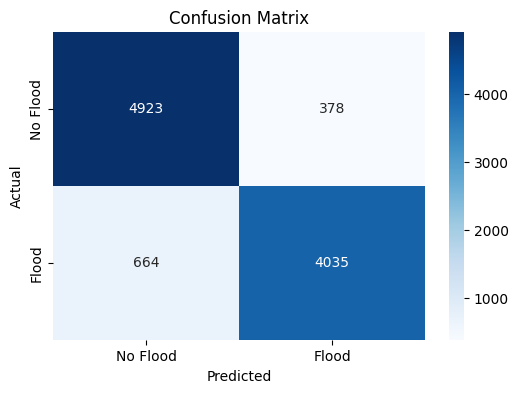

<Figure size 600x400 with 0 Axes>

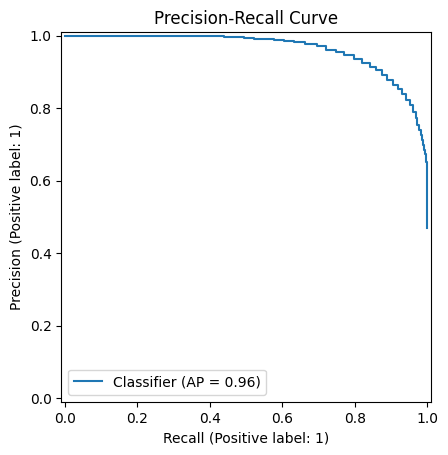

<Figure size 600x400 with 0 Axes>

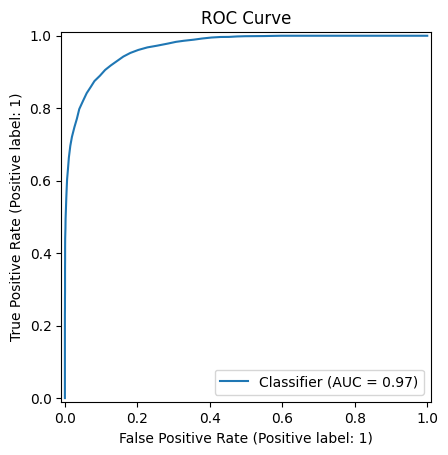

In [ ]:

# 3. Define features and target
X = df.drop(columns=['FloodProbability', 'Flood_Risk'], errors='ignore')  # Drop target and leaking feature
y = df['FloodProbability']

# Convert probabilities to binary labels for stratification and classification
y_binary = (y > 0.5).astype(int)

# 5. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, stratify=y_binary, random_state=42
)

# 6. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Train model
final_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
final_model.fit(X_train_scaled, y_train)

# 8. Predict on test set
y_pred_prob = final_model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

# 9. Evaluation
print("✅ Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("🎯 ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))

# 10. Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flood', 'Flood'],
            yticklabels=['No Flood', 'Flood'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 11. Precision-Recall Curve
plt.figure(figsize=(6, 4))
PrecisionRecallDisplay.from_predictions(y_test, y_pred_prob)
plt.title("Precision-Recall Curve")
plt.show()

# 12. ROC Curve
plt.figure(figsize=(6, 4))
RocCurveDisplay.from_predictions(y_test, y_pred_prob)
plt.title("ROC Curve")
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

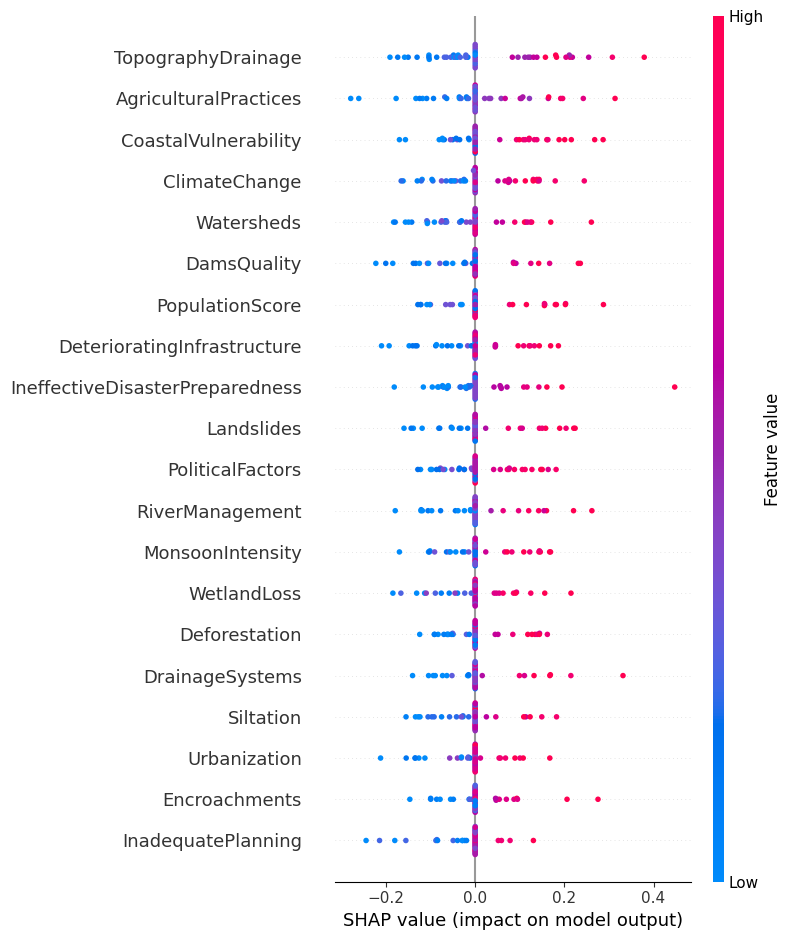

In [ ]:
# 🟧 Section 7: SHAP Explainability
shap.initjs()
background = shap.kmeans(X_train_scaled, 100)
explainer = shap.KernelExplainer(lambda x: final_model.predict(x), background)
shap_values = explainer.shap_values(X_test_scaled[:50])
shap.summary_plot(shap_values, X_test_scaled[:50], feature_names=X.columns)

⏱️ Serial: 7.70s | Parallel: 5.86s


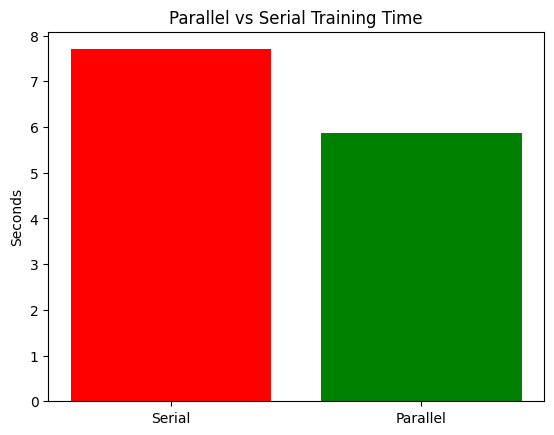

In [ ]:
# 🟥 Section 8: Parallel vs Serial Training Comparison
rf_serial = RandomForestClassifier(n_jobs=1)
start = time.time()
rf_serial.fit(X_train_scaled, y_train)
serial_time = time.time() - start

rf_parallel = RandomForestClassifier(n_jobs=-1)
start = time.time()
rf_parallel.fit(X_train_scaled, y_train)
parallel_time = time.time() - start

print(f"⏱️ Serial: {serial_time:.2f}s | Parallel: {parallel_time:.2f}s")
plt.bar(['Serial', 'Parallel'], [serial_time, parallel_time], color=['red', 'green'])
plt.title("Parallel vs Serial Training Time")
plt.ylabel("Seconds")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

# Predictions from both models
y_pred_serial = rf_serial.predict(X_test_scaled)
y_pred_parallel = rf_parallel.predict(X_test_scaled)

# Accuracy scores
accuracy_serial = accuracy_score(y_test, y_pred_serial) * 100
accuracy_parallel = accuracy_score(y_test, y_pred_parallel) * 100

# Print results
print(f"✅ Serial Accuracy: {accuracy_serial:.2f}%")
print(f"✅ Parallel Accuracy: {accuracy_parallel:.2f}%")

✅ Serial Accuracy: 90.07%
✅ Parallel Accuracy: 89.65%
